## Imports

In [1]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import xml.etree.ElementTree as ET
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from typing import Sequence
from scipy.stats import describe

os.chdir('../')

from res.dispatcher import Dispatcher

rcParams["text.usetex"] = True
rcParams["errorbar.capsize"] = 8.

#rcParams['font.size'] = '14'
#rcParams['pdf.fonttype'] = 42
#rcParams['ps.fonttype'] = 42


## Useful functions 

In [2]:
# Function to get costs dataframes
def get_costs_dataframes(folder, weights=None):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    columns = ['consumed_energy', 'recharging_cost', 'recharging_time', 'travelled_time', 'total']
    df = pd.DataFrame(columns=columns)
    for folder in folders:
        history_path = folder + '/history.xml'
        root = ET.parse(history_path)
        _fleet: ET.Element = root.find('fleet')
        row_dict = {key: [float(attr)] for key, attr in _fleet.attrib.items()}
        costs = (row_dict['travelled_time'][0], row_dict['consumed_energy'][0]/24., row_dict['recharging_time'][0], row_dict['recharging_cost'][0])
        if weights is None:
            total_cost = sum(costs)
        else:
            total_cost = np.dot(np.asarray(costs), np.asarray(weights))  
        row_dict['total'] = total_cost
        row = pd.DataFrame(row_dict)
        df = df.append(row, ignore_index=True)
    
    return df.dropna()

# Function to get average and standard deviations from specified columns
def get_mean_std(df, column_name):
    mean = df[column_name]['mean']
    std = df[column_name]['std']
    return mean, std

# Function to merge a collection of dataframe columns with the same key, and use the specified keys
def merge_df_columns(dfs: Sequence[pd.DataFrame], column: str, keys: Sequence[str]):
    final_df = pd.concat([df[column] for df in dfs], axis=1, keys=keys)
    return final_df

# Function to compare costs using boxplots
def boxplot_comparison(dfs: Sequence[pd.DataFrame], column: str, keys: Sequence[str], title: str=None, return_type: str = 'axes', **kwargs):
    final_df = merge_df_columns(dfs, column, generic_keys)
    axes: plt.Axes = final_df.boxplot(return_type=return_type, **kwargs)
    if title:
        axes.set_title(title)
    return axes

# Function to get costs' series
def get_constraints_series(folder):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    columns = ['time_window_down', 'time_window_upp', 'alpha_up', 'alpha_down', 'max_tour_time', 'cs_capacity', 'total']
    df = pd.DataFrame(columns=columns)
    for folder in folders:
        history_path = folder + '/history.xml'
        root = ET.parse(history_path)
        
        # Fleet level constraints
        for _violated_constraint in root.find('fleet').find('violated_constraints'):
                row = {key: 0 for key in columns}
                row[_violated_constraint.attrib['type']] = 1
                row['total'] = 1
                
        # Vehicle level constraints        
        for _vehicle in root.iter('vehicle'):
            _violated_constraints = _vehicle.find('violated_constraints')
            for _violated_constraint in _violated_constraints:
                row = {key: 0 for key in columns}
                row[_violated_constraint.attrib['type']] = 1
                row['total'] = 1
                df = df.append(row, ignore_index=True)
                
    return df.dropna().sum()

# Function to plot histogram comparions of violated constraints
def compare_constraint_violation_histograms(df, n_col=3, **kwargs):
    n_constraints = len(df.columns)
    n_row = int(n_constraints/n_col) if not n_constraints%n_col else int(n_constraints/n_col) + 1
    fig, axes = plt.subplots(n_row, n_col, **kwargs)
    for i, c_name in enumerate(df.columns, 1):
        column = df[[c_name]].T
        ax = plt.subplot(n_row, n_col, i)
        column.hist(ax=ax)
    return fig

def distance_function(x, y):
    return np.sqrt((x - y)**2)

def get_float_values(e):
    real_value = float(e.attrib['real_value'])
    constraint_value = float(e.attrib['constraint_value'])
    return constraint_value, real_value

# Function to get costs' dataframes from a single history path file
def get_single_history_data(history_path, constraint_names):
    root = ET.parse(history_path)
    stored_data = {key: [] for key in constraint_names}
    
    # Fleet level constraints
    for _violated_constraint in root.find('fleet').find('violated_constraints'):
        key = _violated_constraint.attrib['type']
        constraint_value, real_value = get_float_values(_violated_constraint)
        distance = distance_function(constraint_value, real_value)
        stored_data[key].append(distance)        

    # Vehicle level constraints        
    for _vehicle in root.iter('vehicle'):
        _violated_constraints = _vehicle.find('violated_constraints')
        for _violated_constraint in _violated_constraints:
            key = _violated_constraint.attrib['type']
            constraint_value, real_value = get_float_values(_violated_constraint)
            distance = distance_function(constraint_value, real_value)
            if distance > 100.:
                print(history_path)
            stored_data[key].append(distance) 
    return stored_data
                
# Function to get costs' dataframes
def get_constraints_dataframe(folder, constraint_names, constraint_names_pretty=None):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    data = {key: [] for key in constraint_names}
    
    for folder in folders:
        folder_data = get_single_history_data(folder + '/history.xml', constraint_names)
        for key, val in folder_data.items():
            data[key] += val
            
    columns = ['Constraint', 'Count', 'Average distance', 'Min. distance', 'Max. distance']
    described_data = pd.DataFrame(columns=columns)
    total_count = 0
    for key, val in data.items():
        count = len(val)
        total_count += count
        if count:
            average = np.average(val)
            std = np.std(val)
            data_min = min(val)
            data_max = max(val)
        else:
            average = 0.
            std = 0.
            data_min = 0.
            data_max = 0.
        row = {'Constraint': key, 'Count': count, 'Average distance': average, 'Std Distance': std, 'Min. distance': data_min, 
               'Max. distance': data_max}
        described_data = described_data.append(row, ignore_index=True)
        
    if constraint_names_pretty is not None:
        described_data['Constraint'] = constraint_names_pretty
        
    final_row = {'Constraint': 'Total', 'Count': total_count, 'Average distance': 0., 'Std Distance': 0., 'Min. distance': 0., 
               'Max. distance': 0.}
    
    described_data = described_data.append(final_row, ignore_index=True) 
    described_data.set_index('Constraint', inplace=True)
    return described_data

# Compare two constraint dataframes
def do_constraints_comparison(offline_folder, online_folder):
    off_constraints_se = get_constraints_series(offline_folder)
    on_constraints_se = get_constraints_series(online_folder)
    
    columns = [('Offline', 'Count'), ('Offline', 'Average'), ('Offline', 'Std'), ('Offline', 'Min'), ('Offline', 'Max'),
               ('Online', 'Count'), ('Online', 'Average'), ('Online', 'Std'), ('Online', 'Min'), ('Online', 'Max')]
    
    constraints_comparison_df = pd.concat((off_constraints_se, on_constraints_se), axis=1).T
    constraints_comparison_df.columns =  ('Lower TW', 'Upper TW','SOC Policy Upp', 'SOC Policy Low', 'Max. Tour Time', 'CS Capacity', 'Total')
    constraints_comparison_df.index = ('Offline', 'Offline + Online')
    return constraints_comparison_df.T

## Global parameters 

In [3]:
weights = (0.1 / 2.218, 1. / 0.4364, 1. / 100, 1. / 500)
#weights = (0.1 / 2.218, 1. / 0.4364, 0., 0.)

kwargs = {'notch': True, 'sym': 'o', 'vert': True, 'whis': 1.5, 'meanline': True, 'showmeans': True}

generic_keys = ['Offline ', 'Offline + Online']

constraint_names = ['time_window_down', 'time_window_upp', 'alpha_up', 'alpha_down', 'max_tour_time', 'cs_capacity']
constraint_names_pretty = ['Lower TW', 'UpperTW', 'Upper SOC policy', 'Lower SOC policy', 'Max. tour time', 'CS capacity']

costs_pretty = ['Consumed energy [kWh]', 'Recharging cost [CLP]', 'Recharging time [min]' , 'Travelled time [min]', 'Total']

fig_width, fig_height = 10, 12.941
full_figratio = (fig_width, fig_height)

## With time windows

In [4]:
# Specify locations
offline_folder = 'data/online/instance21/offline_withTimeWindows/'
online_folder = 'data/online/instance21/online_withTimeWindows/'

# Get offline costs
off_df = get_costs_dataframes(offline_folder, weights)
off_statistics = off_df.describe()

# Get online costs
on_df = get_costs_dataframes(online_folder, weights)
on_statistics = on_df.describe()

# Container with both dataframes
dfs = [off_df, on_df]

In [5]:
off_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,56.349847,1.402551e+05,79.274305,289.113191,299.718060
std,1.951541,2.939931e-11,3.283526,8.656114,0.418826
min,50.714917,1.402551e+05,74.252721,274.017076,298.833198
25%,55.551899,1.402551e+05,77.667056,283.952004,299.464576
50%,56.810814,1.402551e+05,79.114996,288.269628,299.679149
75%,57.771591,1.402551e+05,80.303698,293.979369,299.935006
max,59.155571,1.402551e+05,96.820290,311.804154,300.805131


In [6]:
on_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,52.650933,130651.213965,76.724656,294.308376,280.365777
std,3.121731,24403.706199,12.556768,14.042948,49.722622
min,49.184210,103495.846691,61.820063,272.344810,225.376354
25%,49.812237,107257.078552,64.635180,282.575939,232.637295
50%,52.386668,127300.021037,76.585593,292.074908,273.342198
75%,54.465705,147353.994736,85.540627,302.236352,314.254958
max,59.913030,195324.811532,111.313136,329.067974,410.855701


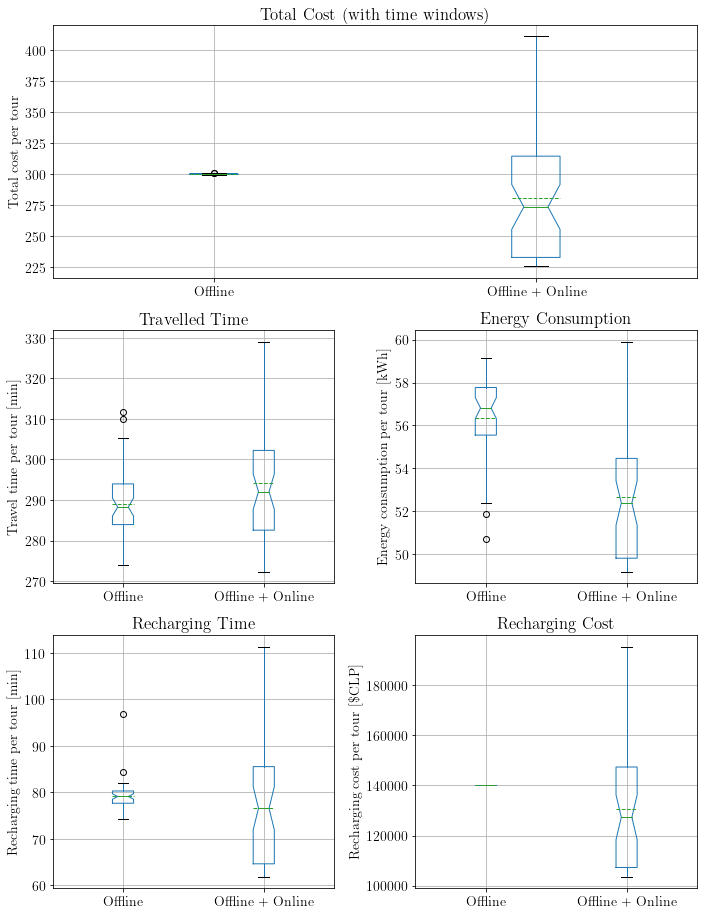

In [7]:
fig = plt.figure(figsize=full_figratio)
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0))
ax3 = plt.subplot2grid((3, 2), (1, 1))
ax4 = plt.subplot2grid((3, 2), (2, 0))
ax5 = plt.subplot2grid((3, 2), (2, 1))

# Total cost
total_cost_bp = boxplot_comparison(dfs, 'total', generic_keys, 'Total Cost (with time windows)', ax=ax1, **kwargs)
#total_cost_bp.axhline(400)   # Expected cost
total_cost_bp.set_ylabel('Total cost per tour')

# Other costs
travelled_time_bp = boxplot_comparison(dfs, 'travelled_time', generic_keys, 'Travelled Time', ax=ax2, **kwargs)
travelled_time_bp.set_ylabel('Travel time per tour [min]')

energy_consumption_bp = boxplot_comparison(dfs, 'consumed_energy', generic_keys, 'Energy Consumption', ax=ax3, **kwargs)
energy_consumption_bp.set_ylabel('Energy consumption per tour [kWh]')

recharging_time_bp = boxplot_comparison(dfs, 'recharging_time', generic_keys, 'Recharging Time', ax=ax4, **kwargs)
recharging_time_bp.set_ylabel('Recharging time per tour [min]')

recharging_cost_bp = boxplot_comparison(dfs, 'recharging_cost', generic_keys, 'Recharging Cost', ax=ax5, **kwargs)
recharging_cost_bp.set_ylabel('Recharging cost per tour [\$CLP]')

plt.tight_layout()

In [8]:
fig.savefig('data/online/instance21/withTW_boxplot_comparison.pdf')

(140254.58873794426, 140255.68873794423)


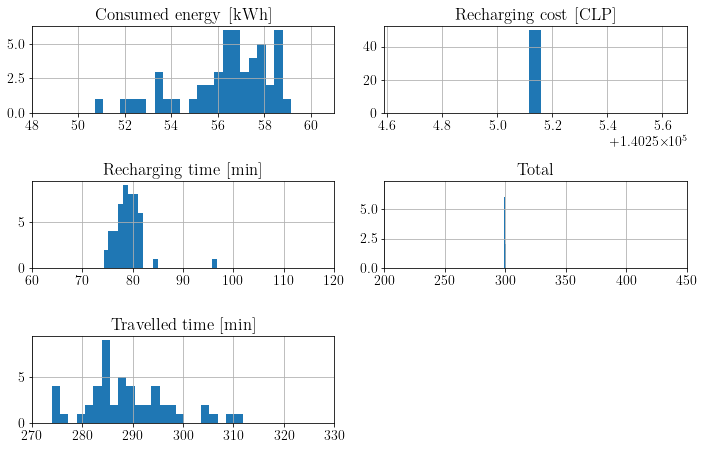

In [9]:
off_df.columns = costs_pretty
axes = off_df.hist(bins=23, figsize=(fig_width, fig_height/2))

axes[0, 0].set_xlim(48, 61)
print(axes[0, 1].get_xlim())
axes[1, 0].set_xlim(60, 120)
axes[1, 1].set_xlim(200, 450)
axes[2, 0].set_xlim(270, 330)    
plt.tight_layout()

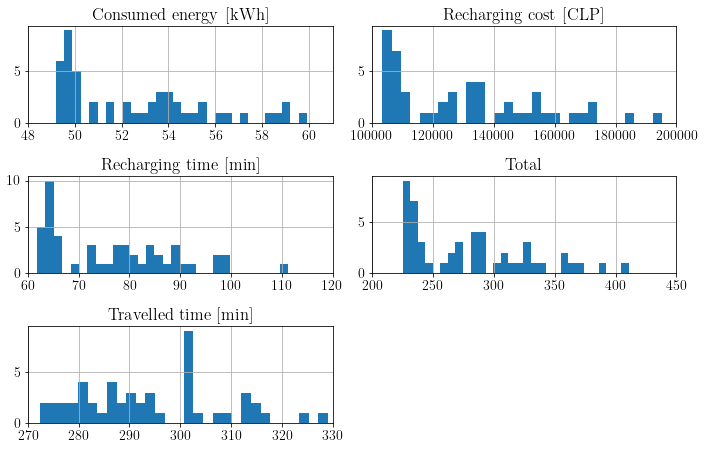

In [10]:
on_df.columns = costs_pretty
axes = on_df.hist(bins=30, figsize=(fig_width, fig_height/2))

axes[0, 0].set_xlim(48, 61)
axes[0, 1].set_xlim(100000, 200000)
axes[1, 0].set_xlim(60, 120)
axes[1, 1].set_xlim(200, 450)
axes[2, 0].set_xlim(270, 330)
plt.tight_layout()

### Constraints violations

In [11]:
offline_constraint_df = get_constraints_dataframe(offline_folder, constraint_names, constraint_names_pretty)
offline_constraint_df.to_csv(f'{offline_folder}constraints_violations_summary_offline.csv')
offline_constraint_df

,Count,Average distance,Min. distance,Max. distance,Std Distance
Constraint,,,,,
Lower TW,0,0.000000,0.000000,0.000000,0.000000
UpperTW,54,2.161169,0.408991,10.355511,1.498824
Upper SOC policy,2,1.651356,0.433827,2.868884,1.217529
Lower SOC policy,111,3.500776,0.217851,11.725688,2.758324
Max. tour time,0,0.000000,0.000000,0.000000,0.000000
CS capacity,0,0.000000,0.000000,0.000000,0.000000
Total,167,0.000000,0.000000,0.000000,0.000000


In [12]:
online_constraint_df = get_constraints_dataframe(online_folder, constraint_names, constraint_names_pretty)
online_constraint_df.to_csv(f'{online_folder}constraints_violations_summary_online.csv')
online_constraint_df

,Count,Average distance,Min. distance,Max. distance,Std Distance
Constraint,,,,,
Lower TW,0,0.000000,0.000000,0.000000,0.000000
UpperTW,8,1.120157,0.171071,2.159374,0.648459
Upper SOC policy,0,0.000000,0.000000,0.000000,0.000000
Lower SOC policy,6,3.318383,0.022955,8.975323,2.984626
Max. tour time,0,0.000000,0.000000,0.000000,0.000000
CS capacity,0,0.000000,0.000000,0.000000,0.000000
Total,14,0.000000,0.000000,0.000000,0.000000


### OnGA execution time

In [13]:
# Function to get costs' dataframes
def get_execution_times(folder):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    execution_times = []
    max_length = -np.infty
    min_length = np.infty
    
    for f in folders:
        et_df = pd.read_csv(f + '/exec_time.csv', index_col=0)
        ets = list(et_df.iloc[:, 0].values)
        execution_times.append(ets)
        max_length = len(ets) if len(ets) > max_length else max_length
        min_length = len(ets) if len(ets) < min_length else min_length
    return execution_times, min_length, max_length

exec_times, min_length, max_length = get_execution_times(online_folder)
print('Max. number of optimization:', max_length)
print('Min. number of optimization:', min_length)

Max. number of optimization: 98
Min. number of optimization: 81


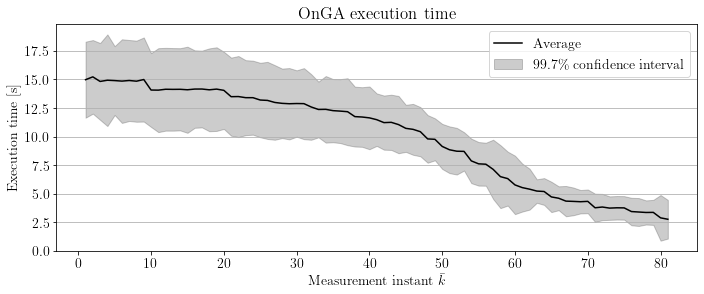

In [14]:
container = np.array([l[:min_length] for l in exec_times])
et_data = pd.DataFrame(container).describe().loc[['mean', 'std']].values
x = range(1, len(et_data[0]) + 1)
y = et_data[0]
y0 = y - 3*et_data[1]
y1 = y + 3*et_data[1]

fig, ax = plt.subplots(figsize=(fig_width, fig_height/3))

ax.fill_between(x, y0, y1, color='k', alpha=.2, interpolate=False, label='99.7\% confidence interval')
ax.plot(x, y, 'k',label='Average')

ax.legend()
ax.set_xlabel(r'Measurement instant $\bar k$')
ax.set_ylabel('Execution time [s]')
ax.grid(axis='y')
ax.set_title('OnGA execution time')

plt.tight_layout()

In [15]:
fig.savefig(f'{online_folder}/exec_time.pdf')

## Without time windows

In [16]:
# Specify locations
offline_folder = 'data/online/instance21/offline_withoutTimeWindows/'
online_folder = 'data/online/instance21/online_withoutTimeWindows/'

# Get offline costs
off_df = get_costs_dataframes(offline_folder, weights)
off_statistics = off_df.describe()

# Get online costs
on_df = get_costs_dataframes(online_folder, weights)
on_statistics = on_df.describe()

# Container with both dataframes
dfs = [off_df, on_df]

In [17]:
off_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,48.981808,92084.367684,57.925079,276.357019,201.884418
std,2.291837,347.688986,6.956421,9.281963,0.808165
min,43.513826,89675.005936,50.313778,254.932844,197.315971
25%,47.285330,92133.538331,53.955919,269.984173,201.702732
50%,49.220831,92133.538331,55.040111,276.776655,201.976122
75%,50.430210,92133.538331,58.695597,282.838810,202.264025
max,54.230374,92133.538331,80.933827,292.350688,203.020846


In [18]:
on_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,38.551695,60517.601001,32.105928,219.952778,134.953823
std,5.619724,37638.777968,19.957114,28.217129,77.112863
min,31.542116,18638.733540,9.867565,184.983870,49.372550
25%,33.978207,29850.818815,15.803375,196.894470,72.096586
50%,36.278161,46879.593557,24.818608,214.221922,107.742805
75%,42.209261,83052.349362,43.968891,232.552770,180.782182
max,54.713059,182043.878610,96.376171,319.792097,384.044291


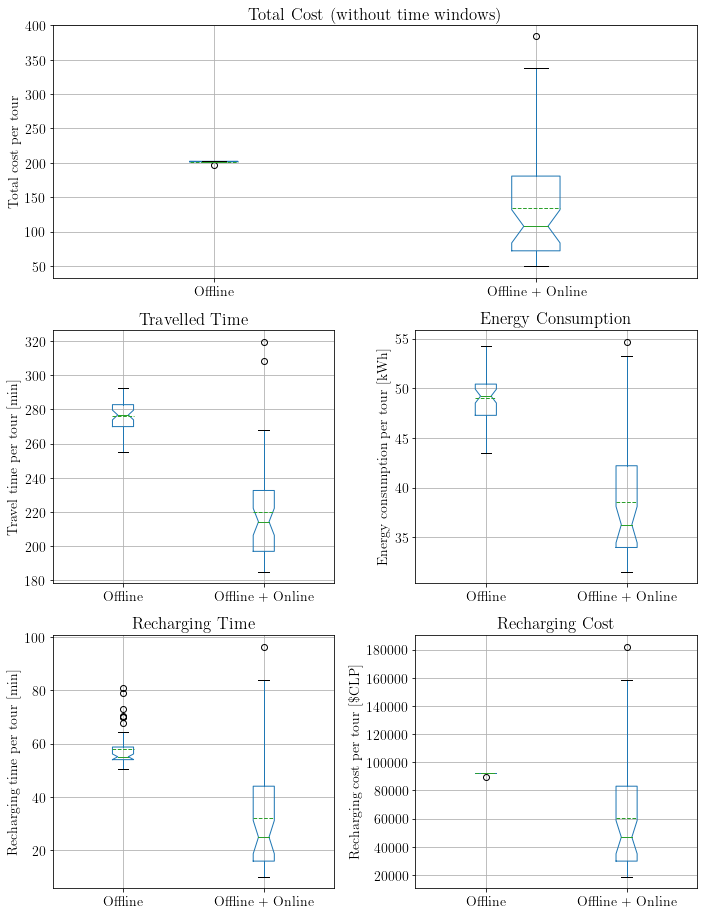

In [19]:
fig = plt.figure(figsize=full_figratio)
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0))
ax3 = plt.subplot2grid((3, 2), (1, 1))
ax4 = plt.subplot2grid((3, 2), (2, 0))
ax5 = plt.subplot2grid((3, 2), (2, 1))

# Total cost
total_cost_bp = boxplot_comparison(dfs, 'total', generic_keys, 'Total Cost (without time windows)', ax=ax1, **kwargs)
#total_cost_bp.axhline(400)   # Expected cost
total_cost_bp.set_ylabel('Total cost per tour')

# Other costs
travelled_time_bp = boxplot_comparison(dfs, 'travelled_time', generic_keys, 'Travelled Time', ax=ax2, **kwargs)
travelled_time_bp.set_ylabel('Travel time per tour [min]')

energy_consumption_bp = boxplot_comparison(dfs, 'consumed_energy', generic_keys, 'Energy Consumption', ax=ax3, **kwargs)
energy_consumption_bp.set_ylabel('Energy consumption per tour [kWh]')

recharging_time_bp = boxplot_comparison(dfs, 'recharging_time', generic_keys, 'Recharging Time', ax=ax4, **kwargs)
recharging_time_bp.set_ylabel('Recharging time per tour [min]')

recharging_cost_bp = boxplot_comparison(dfs, 'recharging_cost', generic_keys, 'Recharging Cost', ax=ax5, **kwargs)
recharging_cost_bp.set_ylabel('Recharging cost per tour [\$CLP]')

plt.tight_layout()

In [20]:
fig.savefig('data/online/instance21/withoutTW_boxplot_comparison.pdf')

(180.0, 325.0)

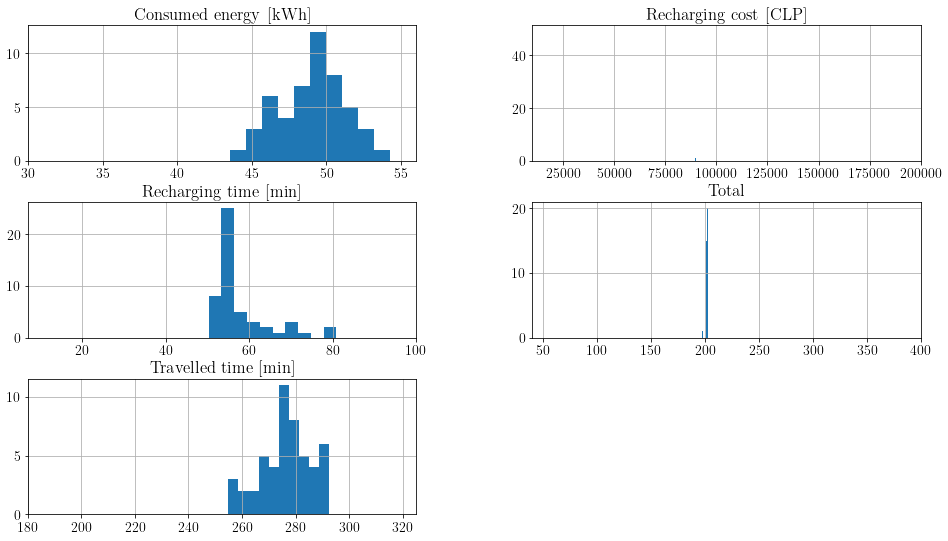

In [21]:
off_df.columns = costs_pretty
axes = off_df.hist(bins=10, figsize=(16,9))

axes[0, 0].set_xlim(30, 56)
axes[0, 1].set_xlim(10000, 200000)
axes[1, 0].set_xlim(7, 100)
axes[1, 1].set_xlim(40, 400)
axes[2, 0].set_xlim(180, 325)

(180.0, 325.0)

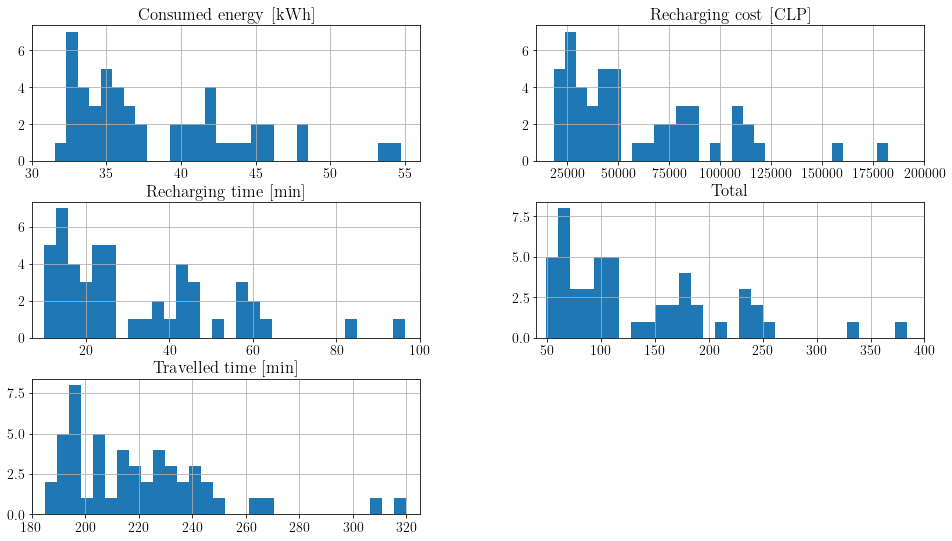

In [22]:
on_df.columns = costs_pretty
axes = on_df.hist(bins=30, figsize=(16,9))

axes[0, 0].set_xlim(30, 56)
axes[0, 1].set_xlim(10000, 200000)
axes[1, 0].set_xlim(7, 100)
axes[1, 1].set_xlim(40, 400)
axes[2, 0].set_xlim(180, 325)

In [23]:
offline_constraint_df = get_constraints_dataframe(offline_folder, constraint_names, constraint_names_pretty)
offline_constraint_df.to_csv(f'{offline_folder}constraints_violations_summary_offline.csv')
offline_constraint_df

,Count,Average distance,Min. distance,Max. distance,Std Distance
Constraint,,,,,
Lower TW,0,0.000000,0.000000,0.000000,0.000000
UpperTW,0,0.000000,0.000000,0.000000,0.000000
Upper SOC policy,15,1.913144,0.096201,5.000000,1.436626
Lower SOC policy,107,4.685845,0.006805,18.005164,3.568659
Max. tour time,0,0.000000,0.000000,0.000000,0.000000
CS capacity,0,0.000000,0.000000,0.000000,0.000000
Total,122,0.000000,0.000000,0.000000,0.000000


In [24]:
online_constraint_df = get_constraints_dataframe(online_folder, constraint_names, constraint_names_pretty)
online_constraint_df.to_csv(f'{online_folder}constraints_violations_summary_online.csv')
online_constraint_df

,Count,Average distance,Min. distance,Max. distance,Std Distance
Constraint,,,,,
Lower TW,0,0.000000,0.000000,0.000000,0.000000
UpperTW,0,0.000000,0.000000,0.000000,0.000000
Upper SOC policy,0,0.000000,0.000000,0.000000,0.000000
Lower SOC policy,3,0.332351,0.165367,0.632259,0.212522
Max. tour time,0,0.000000,0.000000,0.000000,0.000000
CS capacity,0,0.000000,0.000000,0.000000,0.000000
Total,3,0.000000,0.000000,0.000000,0.000000
